# How to Train YOLOv10 Object Detection on a Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2405.14458-b31b1b.svg)](https://arxiv.org/pdf/2405.14458.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/THU-MIG/yolov10)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/YOLO-ARENA)

YOLOv10 is a new generation in the YOLO series for real-time end-to-end object detection. It aims to improve both the performance and efficiency of YOLOs by eliminating the need for non-maximum suppression (NMS) and optimizing model architecture comprehensively. This advancement reduces computational overhead, enhancing both efficiency and capability. YOLOv10 shows state-of-the-art performance and efficiency, with YOLOv10-S being 1.8 times faster than RT-DETR-R18 and having significantly fewer parameters and FLOPs. Additionally, YOLOv10-B demonstrates 46% less latency and 25% fewer parameters compared to YOLOv9-C while maintaining the same performance.

<p align="center">
  <img src="https://raw.githubusercontent.com/vietanhdev/anylearning/3210cd0c214d3a465a61c3fdfe78324d58d17a1f/docs/yolov10/yolov10_latency.svg" width=48%>
  <img src="https://raw.githubusercontent.com/vietanhdev/anylearning/3210cd0c214d3a465a61c3fdfe78324d58d17a1f/docs/yolov10/yolov10_params.svg" width=48%> <br>
  Comparisons with others in terms of latency-accuracy (left) and size-accuracy (right) trade-offs.
</p>

## Install YOLOv10 + Dependencies

In [ ]:
%pip install -q git+https://github.com/THU-MIG/yolov10.git
%pip install huggingface_hub anylearning

In [ ]:
import os

WORKSPACE = os.path.abspath("./workspace")
print("Workspace:", WORKSPACE)

# Copy the dataset into WORKSPACE/raw_dataset
# This is the dataset in format of AnyLabeling
# The structure should be:
# WORKSPACE/raw_dataset
# ├── 0000.jpg
# ├── 0000.json
# ├── 0001.jpg
# ├── 0001.json
# ...
RAW_DATA_ROOT = os.path.join(WORKSPACE, "raw_dataset")

# This is the dataset that you will use for training
DATA_ROOT = os.path.join(WORKSPACE, "dataset")

## Convert and split the data

In [ ]:
# Convert the dataset into the format for YOLOv10
# The structure should be:
# WORKSPACE/dataset
# ├── train
# │   ├── images
# │   │   ├── 0000.jpg
# │   │   ├── 0001.jpg
# │   │   ...
# │   └── labels
# │       ├── 0000.txt
# │       ├── 0001.txt
# │       ...
# ├── val
# │   ├── ...
# └── test
#     ├── ...
!python -m anylearning.converter --json_dir {RAW_DATA_ROOT} --val_size 0.1 --test_size 0.1 --output_dir {DATA_ROOT}

## Download pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [4]:
!mkdir -p {WORKSPACE}/weights
!wget -P {WORKSPACE}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {WORKSPACE}/weights

total 33M
-rw-rw-r-- 1 vietanhdev vietanhdev 11M Thg 5  26 22:54 yolov10n.pt
-rw-rw-r-- 1 vietanhdev vietanhdev 11M Thg 5  26 22:54 yolov10n.pt.1
-rw-rw-r-- 1 vietanhdev vietanhdev 11M Thg 5  26 22:54 yolov10n.pt.2


## Training

In [5]:
from ultralytics import YOLO

data_path = os.path.join(WORKSPACE, "dataset/dataset.yaml")
n_epochs = 10
bs = 16
gpu_id = 0
rng = 0
verbose = True
validate = True

model = YOLO(os.path.join(WORKSPACE, "weights", "yolov10n.pt"))
results = model.train(
    data=data_path,
    epochs=n_epochs,
    batch=bs,
    device=gpu_id,
    verbose=verbose,
    seed=rng,
    val=validate
)

# After this step, you can find the trained model in ./runs/train/exp/weights/best.pt

/home/vietanhdev/miniconda3/envs/anylearning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vietanhdev/miniconda3/envs/anylearning/lib/python3.12/site-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the us

New https://pypi.org/project/ultralytics/8.2.71 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24226MiB)
engine/trainer: task=detect, mode=train, model=/home/vietanhdev/Workspace/Me/anylearning/notebooks/workspace/weights/yolov10n.pt, data=/home/vietanhdev/Workspace/Me/anylearning/notebooks/workspace/dataset/dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

/home/vietanhdev/miniconda3/envs/anylearning/lib/python3.12/site-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, 

AMP: checks passed ✅


/home/vietanhdev/miniconda3/envs/anylearning/lib/python3.12/site-packages/ultralytics/utils/checks.py:641: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):
/home/vietanhdev/miniconda3/envs/anylearning/lib/python3.12/site-packages/ultralytics/engine/trainer.py:276: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /home/vietanhdev/Workspace/Me/anylearning/notebooks/workspace/dataset/train/labels.cache... 697 images, 2 backgrounds, 0 corrupt: 100%|██████████| 697/697 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/vietanhdev/Workspace/Me/anylearning/notebooks/workspace/dataset/train/images/09b6e39ec74143a2c89f280a5f4461a0.JPG: 1 duplicate labels removed



val: Scanning /home/vietanhdev/Workspace/Me/anylearning/notebooks/workspace/dataset/val/labels.cache... 87 images, 1 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/vietanhdev/Workspace/Me/anylearning/notebooks/workspace/dataset/val/images/2dbfa198f26b4fc6d4e21cf5979faf2a.JPG: 1 duplicate labels removed


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/10      3.05G     0.9231      3.534     0.9145     0.9558      3.662     0.8898        229        640: 100%|██████████| 44/44 [00:05<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         87       1903     0.0402      0.483      0.056     0.0377



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/10      3.05G     0.9501      2.406      0.937     0.9763      2.576     0.8983        211        640: 100%|██████████| 44/44 [00:04<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.47it/s]

                   all         87       1903     0.0407      0.518      0.109     0.0796



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/10      3.05G     0.9066      1.918     0.9378     0.9497      2.264     0.8962        193        640: 100%|██████████| 44/44 [00:04<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.69it/s]

                   all         87       1903      0.115      0.409      0.173      0.126



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/10      3.06G     0.8604      1.669     0.9215       0.94      2.116     0.8893        173        640: 100%|██████████| 44/44 [00:04<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.53it/s]

                   all         87       1903      0.292      0.344      0.277      0.209



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/10      3.09G     0.8524      1.487     0.9226      0.903      1.944     0.8965        196        640: 100%|██████████| 44/44 [00:04<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.40it/s]

                   all         87       1903      0.329      0.438      0.343      0.261



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/10      3.09G     0.8247      1.332     0.9221     0.8792      1.781     0.8989        160        640: 100%|██████████| 44/44 [00:03<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.68it/s]

                   all         87       1903      0.421      0.441      0.416      0.318



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/10      3.09G     0.8141      1.237     0.9137     0.8653      1.658     0.8925        175        640: 100%|██████████| 44/44 [00:03<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.48it/s]

                   all         87       1903      0.476      0.496      0.496      0.381



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/10      3.09G     0.8144      1.162     0.9162     0.8766      1.581     0.8946        170        640: 100%|██████████| 44/44 [00:04<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.26it/s]

                   all         87       1903      0.534       0.49      0.531       0.41



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/10      3.09G     0.7962      1.076     0.9085     0.8424      1.495     0.8879        243        640: 100%|██████████| 44/44 [00:04<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.62it/s]

                   all         87       1903      0.562      0.529       0.58      0.451



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/10      3.12G     0.7746      1.011     0.9042     0.8293      1.423     0.8822        122        640: 100%|██████████| 44/44 [00:04<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.05it/s]

                   all         87       1903      0.625       0.53      0.604      0.472



10 epochs completed in 0.015 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24226MiB)
YOLOv10n summary (fused): 285 layers, 2697146 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


                   all         87       1903      0.625      0.531      0.604      0.472
                    xe         87        235      0.553      0.384      0.464      0.353
                 tuong         87        120       0.63      0.342      0.431      0.313
                    si         87        593      0.721      0.796      0.824      0.653
                    ma         87        248      0.621      0.542      0.593      0.475
                   vua         87        236      0.621      0.614      0.705       0.55
                   tot         87        233       0.67      0.468      0.604      0.478
                  phao         87        238      0.556      0.567      0.608      0.481
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train


## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.


0: 384x640 7 sis, 2 mas, 4 vuas, 6 phaos, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


/home/vietanhdev/miniconda3/envs/anylearning/lib/python3.12/site-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, 

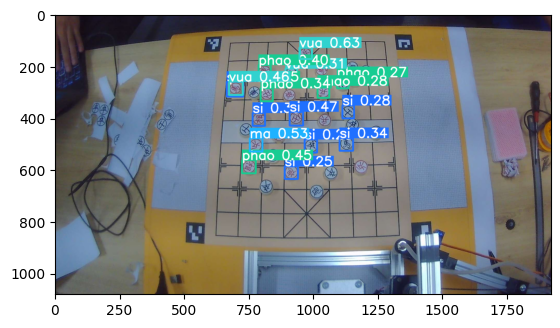

In [6]:
import cv2
from ultralytics import YOLOv10
from matplotlib.pyplot import imshow

model = YOLOv10("runs/detect/train/weights/best.pt")

img = cv2.imread("workspace/dataset/test/images/4dc81ebe5d8569863890a192043c86bb.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = model.predict(img)

# Process results list
result = results[0]  # first image results
boxes = result.boxes  # Boxes object for bounding box outputs
masks = result.masks  # Masks object for segmentation masks outputs
keypoints = result.keypoints  # Keypoints object for pose outputs
probs = result.probs  # Probs object for classification outputs
obb = result.obb  # Oriented boxes object for OBB outputs
image = result.plot()  # plot predictions

imshow(image)


**NOTE:** Let's randomly select an image from our validation set and visualize the results.